In [1]:
import os
import pandas as pd
from MulticoreTSNE import MulticoreTSNE as TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir -p sandbox_am #let's put all stuff in the sandbox
os.chdir("sandbox_am")

### Download a sample of ActinoMock Nanopore data

Download the sample file as stated in [https://github.com/Lizhen0909/pyLSHVec](https://github.com/Lizhen0909/pyLSHVec). Here use wget to download it or just download it manually

In [7]:
if not os.path.exists('ActinoMock_Nanopore.seq.gz'):
    !wget http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz

--2021-06-21 14:44:06--  http://ww2.cs.fsu.edu/~lshi/ActinoMock_Nanopore.seq.gz
Resolving ww2.cs.fsu.edu (ww2.cs.fsu.edu)... 128.186.122.20
Connecting to ww2.cs.fsu.edu (ww2.cs.fsu.edu)|128.186.122.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480042209 (458M) [application/x-gzip]
Saving to: ‘ActinoMock_Nanopore.seq.gz’

100%[======================================>] 480,042,209 25.0MB/s   in 16s    

2021-06-21 14:44:22 (28.9 MB/s) - ‘ActinoMock_Nanopore.seq.gz’ saved [480042209/480042209]



In [8]:
!cat ActinoMock_Nanopore.seq.gz | gunzip > data.seq

### encode  reads

In [6]:
!python3 ../../scripts/fastseq/hashSeq.py -i data.seq --hash lsh --batch_size 12800 -o data.hash --n_thread=8 -k 15 --hash_size 25 --bucket 67108864 > /dev/null  2> error.log

### train a model

In [7]:
#change epoch to 1 to save time
!../../lshvec skipgram -input data.hash -output model  -epoch 5 -dim 100 -lr 0.1

Read 1639M words
Number of words:  7744373
Number of labels: 0
Progress: 100.0% words/sec/thread:   47112 lr:  0.000000 loss:  0.065489 ETA:   0h 0m 4m42mm ETA:   7h26mm23m  7h23mh22mmm  7h20mmm 0.258502 ETA:   7h17mh16mh16m16mh15m15m loss:  0.247115 ETA:   7h14mm  7h12m10mh 9mh 9m 9m 8mh 8m  7h 7mh 4mmh 3mh 1m 1m 1mh 0m59m58m 12.8% words/sec/thread:   47397 lr:  0.087152 loss:  0.207146 ETA:   6h58mh58mm54m  6h54m53m46m ETA:   6h45m ETA:   6h44mm 0.081615 loss:  0.166689 ETA:   6h31m31mh30m29m27mmm ETA:   6h23m22mmm17mm14mmmmh 8mh 8mh 6m 6m 0.149192 ETA:   6h 4mm59m  5h58m55mm 0.144130 ETA:   5h50m 0.142322 ETA:   5h45mh44mmmh41mmm 0.139157 ETA:   5h36m34mmm28m  5h26m  5h23m22mm18mmm16m14mm 6mm 3m57m  4h56mm ETA:   4h50m ETA:   4h45m44m42mm31mm31m  4h29m28mh27m  4h24m21mmh16m15m  4h15m12mh11mmm58mm47mm ETA:   3h44mm  3h36m  3h35m loss:  0.108933 ETA:   3h35m34mm  3h33m31mh29m  3h25m  3h24mm  3h21mh19m19mmh17m16m11m56m56m52m52m50m49m48mmmh42mmmh15mm  1h55mmh52mmm  1h43mh38mh34m27m24mmm

### Now the model is trained.  To visualize it, first get vectors of reads. 

In [8]:
def read_embedding(fname):
    with open(fname) as fin:
        lines=list(fin)
    assert len(lines)>1
    first_line=lines[0]
    num_word, dim_vec = [int(u) for u in first_line.split(" ")]
    assert len(lines)==num_word+1
    ret ={}
    for line in lines[1:]:
        lst = line.strip().split(" ")
        assert len(lst)==dim_vec+1, line
        if lst[0]=='</s>': continue
        word = int(lst[0])
        vec = np.array([float(u) for u in lst[1:]])
        ret[word]=vec
    return ret,dim_vec

embedding,dim_vec = read_embedding("model.vec")
seqvectors = []
lines=[]
with open("data.hash") as fin:
    for line in fin:
        if len(lines)>=20000: break  #The data is already shuffled, so just take a few from head
        lines.append(line)
for i,line in enumerate(lines):
    words = [int(u) for u in line.strip().split(" ")]
    vec = [embedding[u] for u in words if u in embedding]
    seqvectors.append(np.mean(vec,0) if len(vec)>0 else None)#np.zeros([dim_vec],dtype=np.float32))
    #if i>10: break    

### Next get the labels

In [9]:
seqs = pd.read_csv("data.seq",sep='\t', header=None, usecols=[0,1],index_col=0, nrows=20000)
seqs.columns=['id']
seqs['organism']=seqs['id'].map(lambda u: u.split('-')[1])
seqs['class']=seqs['id'].map(lambda u: u.split('-')[2])
seqs['phylum']=seqs['id'].map(lambda u: u.split('-')[3])
seqs['vec']=seqvectors
seqs.head()

,id,organism,class,phylum,vec
0,,,,,
47914,47914-2616644829-Gammaproteobacteria-Proteobac...,2616644829,Gammaproteobacteria,Proteobacteria,"[0.15246312980037077, 0.006180314055980623, 0...."
78419,78419-2623620618-Gammaproteobacteria-Proteobac...,2623620618,Gammaproteobacteria,Proteobacteria,"[0.15829108022061245, 0.030191946629871784, 0...."
67045,67045-2623620617-Gammaproteobacteria-Proteobac...,2623620617,Gammaproteobacteria,Proteobacteria,"[0.14641158768695445, 0.055608367484122095, 0...."
27710,27710-2615840601-Alphaproteobacteria-Proteobac...,2615840601,Alphaproteobacteria,Proteobacteria,"[0.14354643256517433, 0.03226075930530218, 0.0..."
31701,31701-2615840697-Gammaproteobacteria-Proteobac...,2615840697,Gammaproteobacteria,Proteobacteria,"[0.1485375730887018, 0.01843596217372326, 0.04..."


### Now train TSNE

In [10]:
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)
X=np.array(list(seqs['vec'].values))
X.shape

(20000, 100)

In [11]:
%time Y = tsne.fit_transform(X)

CPU times: user 5min 9s, sys: 0 ns, total: 5min 9s
Wall time: 1min 17s


### visualization

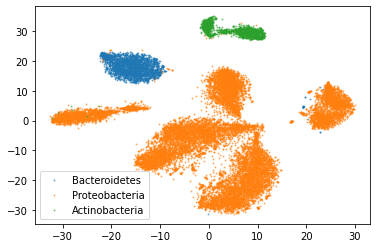

In [12]:
labels=seqs['phylum'].values
legends=list(set(labels))
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)
plt.legend(legends)

['Gammaproteobacteria', 'Alphaproteobacteria', 'Flavobacteriia', 'Actinobacteria']


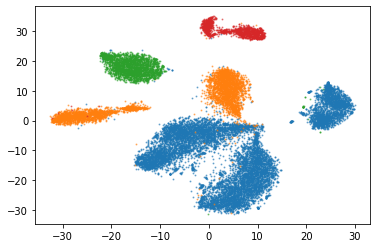

In [13]:
labels=seqs['class'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)

['2615840697', '2623620557', '2617270709', '2616644829', '2615840533', '2623620567', '2623620618', '2615840527', '2615840646', '2615840601', '2623620617']


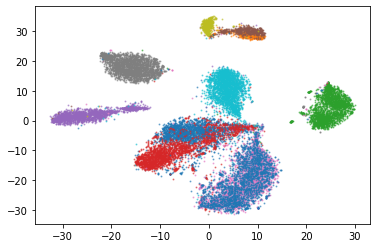

In [14]:
labels=seqs['organism'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)